Szimilaritás mátrix mérete: (445, 445)
Interakciós mátrix mérete: (445, 445)
Accuracy: 0.9883
AUPR: 0.1123


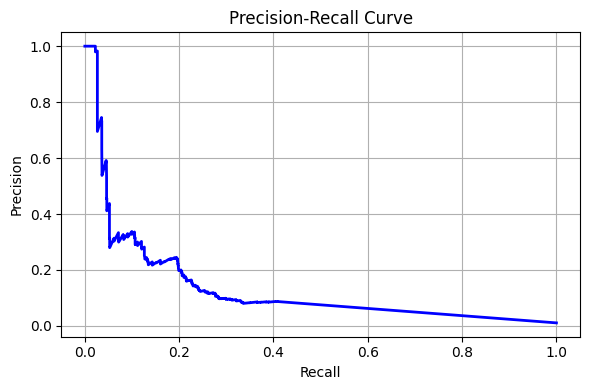

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, average_precision_score, precision_recall_curve
import urllib.request

simmat_url = "http://web.kuicr.kyoto-u.ac.jp/supp/yoshi/drugtarget/e_simmat_dc.txt"
admat_url = "http://web.kuicr.kyoto-u.ac.jp/supp/yoshi/drugtarget/e_admat_dgc.txt"

urllib.request.urlretrieve(simmat_url, "e_simmat_dc.txt")
urllib.request.urlretrieve(admat_url, "e_admat_dgc.txt")

# Betöltés fejléc nélkül
simmat_df = pd.read_csv("e_simmat_dc.txt", sep='\t', index_col=0)
admat_df = pd.read_csv("e_admat_dgc.txt", sep='\t', index_col=0)

simmat = simmat_df.to_numpy()
admat = admat_df.to_numpy()
admat = admat[:445] # matrix meretek nem egyeztek

print("Szimilaritás mátrix mérete:", simmat.shape)
print("Interakciós mátrix mérete:", admat.shape)

# Predikciós függvény: weighted kNN
def predict_interactions(simmat, admat, k=5):
    num_drugs, num_targets = admat.shape
    pred_scores = np.zeros_like(admat, dtype=float)

    for i in range(num_drugs):
        similar_indices = np.argsort(simmat[i])[::-1][1:k+1]  # saját magát kihagyjuk
        weights = simmat[i][similar_indices]
        neighbors_interactions = admat[similar_indices]

        pred_scores[i] = np.dot(weights, neighbors_interactions) / (np.sum(weights) + 1e-8)

    return pred_scores

# Predikció
predicted_scores = predict_interactions(simmat, admat, k=5)

# Értékelés
y_true = admat.flatten()
y_scores = predicted_scores.flatten()
y_pred = (y_scores >= 0.5).astype(int)

accuracy = accuracy_score(y_true, y_pred)
aupr = average_precision_score(y_true, y_scores)

print(f"Accuracy: {accuracy:.4f}")
print(f"AUPR: {aupr:.4f}")

# PR görbe
precision, recall, _ = precision_recall_curve(y_true, y_scores)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.tight_layout()
plt.show()


Feature mátrix mérete: (198025, 890)
ML Accuracy: 0.9891
ML AUPR: 0.1957


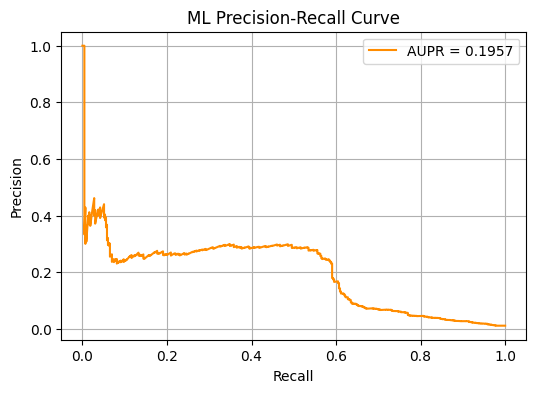

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, average_precision_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler

X = [] # feature
y = [] # label

num_drugs, num_targets = admat.shape

for i in range(num_drugs):
    for j in range(num_targets):
        # - i-edik gyógyszer szimilaritása az összes többihez
        # - j-edik fehérje interakciói más gyógyszerekkel
        drug_feat = simmat[i]
        target_feat = admat[:, j]

        combined = np.concatenate([drug_feat, target_feat])
        X.append(combined)

        # van-e interakció
        y.append(admat[i][j])

X = np.array(X)
y = np.array(y)

print("Feature mátrix mérete:", X.shape)

# 2. Skálázás
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Tanító / teszt szétválasztás
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 4. Modell tanítása
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# 5. Előrejelzés
y_pred_probs = clf.predict_proba(X_test)[:, 1]
y_pred_binary = (y_pred_probs >= 0.5).astype(int)

# 6. Kiértékelés
acc = accuracy_score(y_test, y_pred_binary)
aupr = average_precision_score(y_test, y_pred_probs)

print(f"ML Accuracy: {acc:.4f}")
print(f"ML AUPR: {aupr:.4f}")

# PR-görbe
precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f"AUPR = {aupr:.4f}", color="darkorange")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("ML Precision-Recall Curve")
plt.grid(True)
plt.legend()
plt.show()


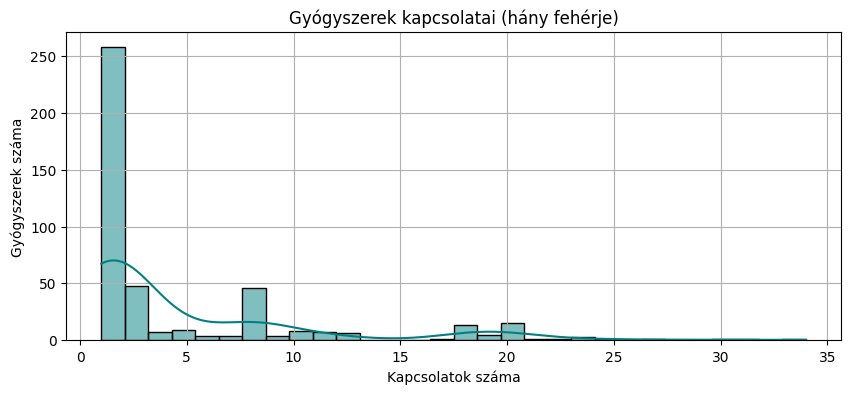

In [17]:
import seaborn as sns

# Gyógyszerek interakciószáma
drug_interactions = admat.sum(axis=1)

plt.figure(figsize=(10,4))
sns.histplot(drug_interactions, bins=30, color='teal', kde=True)
plt.title("Gyógyszerek kapcsolatai (hány fehérje)")
plt.xlabel("Kapcsolatok száma")
plt.ylabel("Gyógyszerek száma")
plt.grid(True)
plt.show()


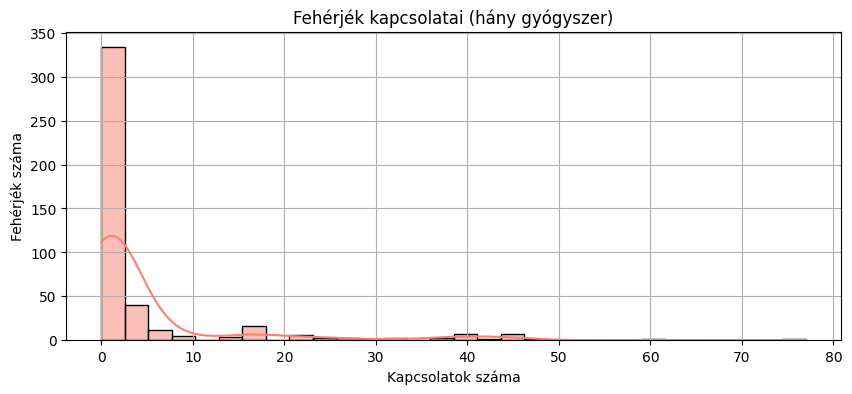

In [18]:
# Fehérjék interakciószáma
target_interactions = admat.sum(axis=0)

plt.figure(figsize=(10,4))
sns.histplot(target_interactions, bins=30, color='salmon', kde=True)
plt.title("Fehérjék kapcsolatai (hány gyógyszer)")
plt.xlabel("Kapcsolatok száma")
plt.ylabel("Fehérjék száma")
plt.grid(True)
plt.show()


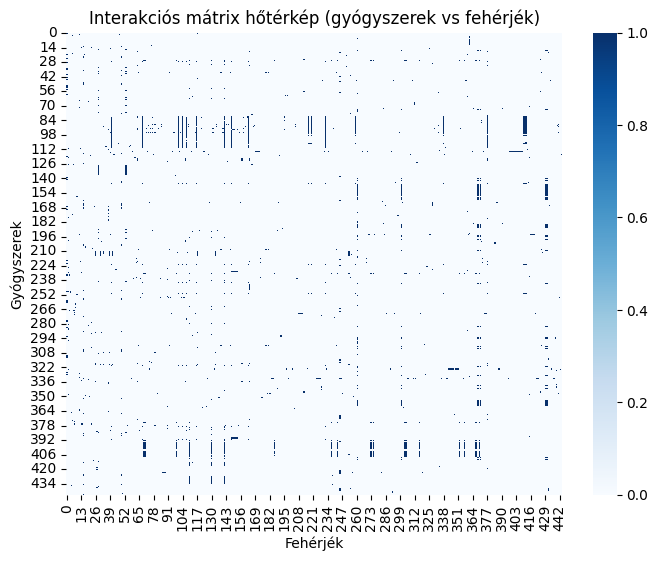

In [19]:
plt.figure(figsize=(8,6))
sns.heatmap(admat, cmap="Blues", cbar=True)
plt.title("Interakciós mátrix hőtérkép (gyógyszerek vs fehérjék)")
plt.xlabel("Fehérjék")
plt.ylabel("Gyógyszerek")
plt.show()


Feature mátrix mérete: (198025, 890)
RF Accuracy: 0.9976
RF AUPR: 0.8936


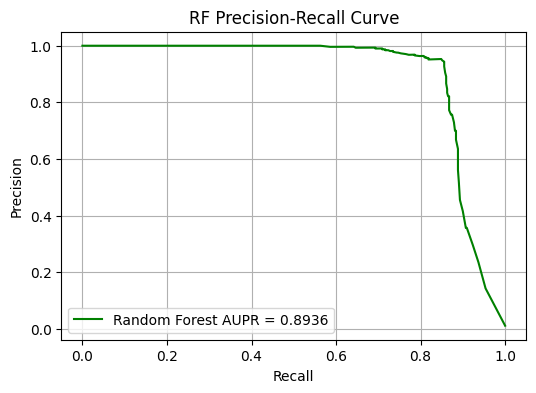

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, average_precision_score, precision_recall_curve

X = [] # feature
y = [] # label

num_drugs, num_targets = admat.shape

for i in range(num_drugs):
    for j in range(num_targets):
        # Jellemzők (X):
        # - i-edik gyógyszer szimilaritása az összes többihez (445-dimenziós vektor)
        # - j-edik fehérje interakciói más gyógyszerekkel (445-dimenziós vektor)
        drug_feat = simmat[i]  # (445,)
        target_feat = admat[:, j]  # (445,)

        combined = np.concatenate([drug_feat, target_feat])
        X.append(combined)

        # Label (y): van-e interakció
        y.append(admat[i][j])

X = np.array(X)
y = np.array(y)

print("Feature mátrix mérete:", X.shape)  # (445*445, 890)

# 2. Skálázás
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Tanító / teszt szétválasztás
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Random Forest modell
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_clf.fit(X_train, y_train)

# Előrejelzés
y_pred_probs_rf = rf_clf.predict_proba(X_test)[:, 1]
y_pred_rf = (y_pred_probs_rf >= 0.5).astype(int)

# Kiértékelés
acc_rf = accuracy_score(y_test, y_pred_rf)
aupr_rf = average_precision_score(y_test, y_pred_probs_rf)

print(f"RF Accuracy: {acc_rf:.4f}")
print(f"RF AUPR: {aupr_rf:.4f}")

# PR görbe
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_probs_rf)

plt.figure(figsize=(6,4))
plt.plot(recall_rf, precision_rf, label=f"Random Forest AUPR = {aupr_rf:.4f}", color="green")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("RF Precision-Recall Curve")
plt.grid(True)
plt.legend()
plt.show()
